Accuracy: 0.9838565022421525
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.92      0.96      0.94       149

    accuracy                           0.98      1115
   macro avg       0.96      0.97      0.97      1115
weighted avg       0.98      0.98      0.98      1115



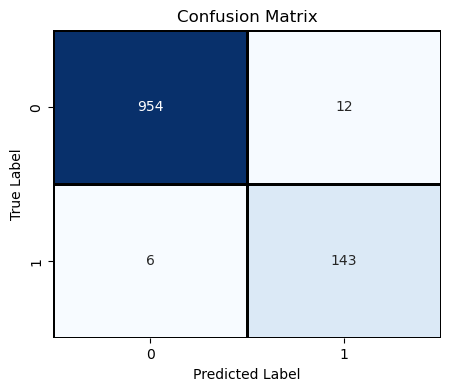

In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re

# Görselleştirme ve Confusion Matrix için:
import matplotlib.pyplot as plt
import seaborn as sns

# Model başarı metrikleri:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv("../data/SMSSpamCollection", sep='\t', header=None, names=["label", "text"])
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# Eğitim/test ayrımı
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label_num, test_size=0.2, random_state=42)

class MyMultinomialNB:
    def __init__(self):
        self.class_priors = {}
        self.word_counts = {}
        self.vocab = set()
        self.class_totals = {}

    def tokenize(self, text):
        # Basit tokenizer (noktalama vs. temizlenir, küçük harf yapılır)
        return re.findall(r"\b\w+\b", text.lower())

    def fit(self, X, y):   # training
        # class -> kelime -> frekans
        self.word_counts = defaultdict(lambda: defaultdict(int))
        self.class_totals = defaultdict(int)

        # class -> öncül olasılık
        total_docs = X.shape[0]
        class_counts = defaultdict(int)

        for text, label in zip(X, y):
            class_counts[label] += 1
            tokens = self.tokenize(text)
            for token in tokens:
                self.vocab.add(token)
                self.word_counts[label][token] += 1
                self.class_totals[label] += 1

        self.class_priors = {c: np.log(count / total_docs) for c, count in class_counts.items()}

    def predict(self, X):
        result = []
        for text in X:
            tokens = self.tokenize(text)
            class_scores = {}
            for c in self.class_priors:
                log_prob = self.class_priors[c]
                for token in tokens:
                    # Laplace smoothing
                    word_freq = self.word_counts[c][token] if token in self.word_counts[c] else 0
                    log_prob += np.log((word_freq + 1) / (self.class_totals[c] + len(self.vocab)))
                class_scores[c] = log_prob
            result.append(max(class_scores, key=class_scores.get))
        return result

    def predict_proba(self, X):
        proba_list = []
        for text in X:
            tokens = self.tokenize(text)
            class_scores = {}
            for c in self.class_priors:
                log_prob = self.class_priors[c]
                for token in tokens:
                    word_freq = self.word_counts[c][token] if token in self.word_counts[c] else 0
                    log_prob += np.log((word_freq + 1) / (self.class_totals[c] + len(self.vocab)))
                class_scores[c] = log_prob
            max_log = max(class_scores.values())
            exp_scores = {c: np.exp(score - max_log) for c, score in class_scores.items()}
            total_exp = sum(exp_scores.values())
            proba = [exp_scores.get(c, 0)/total_exp for c in sorted(self.class_priors.keys())]
            proba_list.append(proba)
        return np.array(proba_list)

from sklearn.base import BaseEstimator, ClassifierMixin

class MyMultinomialNBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = MyMultinomialNB()

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

model = MyMultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix görsel olarak göster
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=1, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



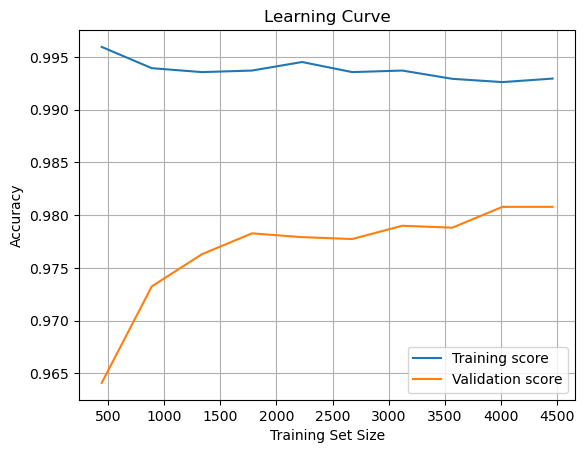

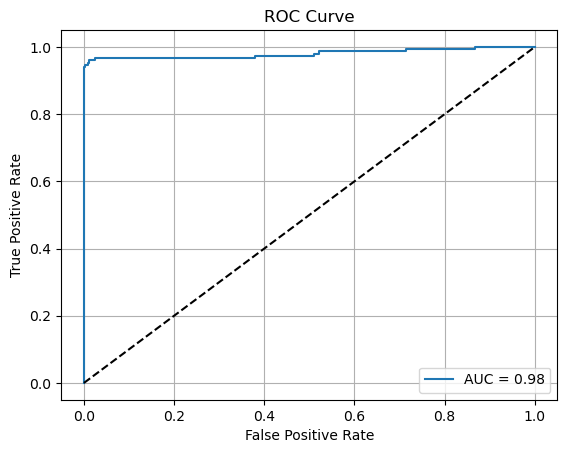

Accuracy: 0.984 (0.975 – 0.990)


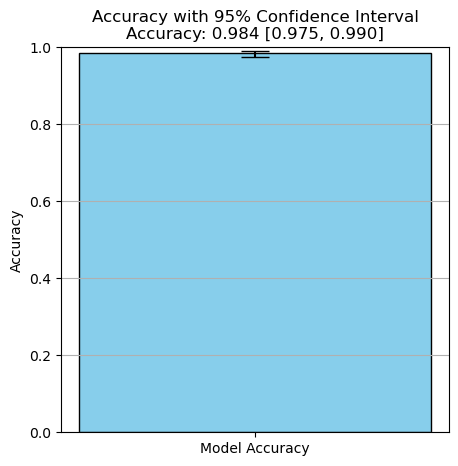

In [5]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

X_text = df["text"]
y = df["label_num"]

train_sizes, train_scores, test_scores = learning_curve(
    MyMultinomialNBWrapper(), X_text, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Validation score')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import roc_curve, auc

model = MyMultinomialNBWrapper() #scikit learn uyumlu wrapper fonksiyonumuz
model.fit(X_train, y_train)  # Ham verileri veriyoruz
y_pred = model.predict(X_test)  # Ham metinler
y_prob = model.predict_proba(X_test)[:, 1] # Ham metinler

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


from statsmodels.stats.proportion import proportion_confint

n = len(y_test)
correct = (np.array(y_test) == np.array(y_pred)).sum()
accuracy = correct / n

conf_int_low, conf_int_high = proportion_confint(correct, n, alpha=0.05, method='wilson')
print(f"Accuracy: {accuracy:.3f} ({conf_int_low:.3f} – {conf_int_high:.3f})")

# Bar grafiği oluştur
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.bar(1, accuracy, yerr=[[accuracy - conf_int_low], [conf_int_high - accuracy]],
        capsize=10, color='skyblue', edgecolor='black')

plt.xticks([1], ["Model Accuracy"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title(f"Accuracy with 95% Confidence Interval\nAccuracy: {accuracy:.3f} [{conf_int_low:.3f}, {conf_int_high:.3f}]")
plt.grid(axis='y')

plt.show()